## Import libraries and data

In [1]:
import numpy as np 
import pandas as pd 
import os

# for working on Kaggle

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import io
import re
import shutil
import string

#import tensorflow 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, Bidirectional, SimpleRNN, GRU, LSTM, LeakyReLU
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
!pip install tensorflow-addons -q
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

     |████████████████████████████████| 1.1 MB 7.8 MB/s 


In [2]:
!python -m spacy download en_core_web_md -q

import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS

nlp = en_core_web_md.load()

     |████████████████████████████████| 33.5 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
# for working on kaggle
#tweets = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

# for working in colab
tweets = pd.read_csv("/content/train.csv")

tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Clean up tweets

In [4]:
# add location name to text if it exists
tweets['location'] = tweets['location'].fillna(" ")
tweets['text_location'] = tweets['text'] + " " + tweets['location']

# remove https
tweets['text_clean'] = tweets['text_location'].str.replace(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", " ")
#remove tags
tweets['text_clean'] = tweets['text_clean'].str.replace(r"@[-a-zA-Z0-9@:%._\+~#=]{1,256}\s", " ")
# remove control characters  
tweets['text_clean'] = tweets['text_clean'].str.replace(r"\&(.*?)\;", " ")
tweets['text_clean'] = tweets['text_clean'].str.replace(r"\n", " ")

#remove emojis and other special characters
tweets['text_clean'] = tweets['text_clean'].str.replace(r"åÊ", " ")
tweets['text_clean'] = tweets['text_clean'].str.replace(r"ÛÓ", " ")
tweets['text_clean'] = tweets['text_clean'].str.replace(r"ÛÒ", " ")
tweets['text_clean'] = tweets['text_clean'].str.replace(r"Û", " ")
tweets['text_clean'] = tweets['text_clean'].str.replace(r"[!@#$%^&*(),.?\\/\":{}|<>ã¢;ª-]", " ")
#tweets['text_clean'] = tweets['text_clean'].str.replace(r"[0-9]+", " ")

#remove single characters
tweets['text_clean'] = tweets['text_clean'].str.replace(r"\s[a-z]\s", " ")
tweets['text_clean'] = tweets['text_clean'].str.replace(r"\s[a-z]\s", " ")

# substitute capitalized character with lower case, tokenize, lemmatize, remove stop words
tweets['text_clean'] = tweets['text_clean'].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
tweets['text_clean'] = tweets['text_clean'].apply(lambda x: x.replace(" +"," ").lower().strip())
tweets['text_clean'] = tweets['text_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
tweets['text_clean'] = tweets['text_clean'].str.replace(r"[']", " ")
tweets['text_clean'] = tweets['text_clean'].str.replace(r"[']", " ")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The defau

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

tweets[['text_location', 'text_clean']].head(50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,text_location,text_clean
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,resident ask shelter place notify officer evacuation shelter place order expect
3,"13,000 people receive #wildfires evacuation orders in California",13 000 people receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got send photo ruby alaska smoke wildfire pour school
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,rockyfire update california hwy 20 close direction lake county fire cafire wildfire
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",flood disaster heavy rain cause flash flooding street manitou colorado spring area
7,I'm on top of the hill and I can see a fire in the woods...,hill fire wood
8,There's an emergency evacuation happening now in the building across the street,emergency evacuation happen building street
9,I'm afraid that the tornado is coming to our area...,afraid tornado come area


In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(tweets.text_clean)

tweets["text_encoded"] = tokenizer.texts_to_sequences(tweets.text_clean)

#tweets["len_text"] = tweets["text_encoded"].apply(lambda x: len(x))
#tweets = tweets[tweets["len_text"]!=0]
#tweets = tweets.drop('len_text', axis=1)

tweets.head(20)

,id,keyword,location,text,target,text_location,text_clean,text_encoded
0,1,NaN,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason earthquake allah forgive,"[4060, 468, 218, 1456, 2257]"
1,4,NaN,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[148, 3, 150, 322, 6010, 4061, 64]"
2,5,NaN,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,resident ask shelter place notify officer evacuation shelter place order expect,"[1352, 509, 1749, 344, 6011, 358, 224, 1749, 344, 323, 449]"
3,6,NaN,,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California",13 000 people receive wildfire evacuation order california,"[664, 2258, 8, 2654, 100, 224, 323, 7]"
4,7,NaN,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got send photo ruby alaska smoke wildfire pour school,"[309, 219, 146, 6012, 1263, 225, 100, 2655, 124]"
5,8,NaN,,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,rockyfire update california hwy 20 close direction lake county fire cafire wildfire,"[2656, 199, 7, 1353, 574, 398, 1004, 598, 168, 3, 4062, 100]"
6,10,NaN,,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",flood disaster heavy rain cause flash flooding street manitou colorado spring area,"[34, 16, 729, 184, 57, 730, 485, 374, 6013, 244, 644, 112]"
7,13,NaN,,I'm on top of the hill and I can see a fire in the woods...,1,I'm on top of the hill and I can see a fire in the woods...,hill fire wood,"[698, 3, 1457]"
8,14,NaN,,There's an emergency evacuation happening now in the building across the street,1,There's an emergency evacuation happening now in the building across the street,emergency evacuation happen building street,"[20, 224, 206, 37, 374]"
9,15,NaN,,I'm afraid that the tornado is coming to our area...,1,I'm afraid that the tornado is coming to our area...,afraid tornado come area,"[2259, 324, 17, 112]"


In [8]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(tweets.text_encoded, padding="post")

In [47]:
# verify if the dataset is balanced
tweets.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [10]:
from sklearn.model_selection import train_test_split
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(text_pad, tweets.target, test_size=0.1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

### Model 1: dense sequential network

In [48]:
embedding_dim=32 

vocab_size = len(tokenizer.word_index)

model = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(1, activation="sigmoid") 
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          452160    
                                                                 
 global_average_pooling1d_6   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_24 (Dense)            (None, 128)               4224      
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                      

In [49]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])

In [50]:
model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=10)

Epoch 1/10
108/108 [==============================] - 2s 9ms/step - loss: 0.6770 - f1_score: 0.0081 - val_loss: 0.6636 - val_f1_score: 0.0000e+00
Epoch 2/10
108/108 [==============================] - 1s 8ms/step - loss: 0.5569 - f1_score: 0.5762 - val_loss: 0.5058 - val_f1_score: 0.7545
Epoch 3/10
108/108 [==============================] - 1s 8ms/step - loss: 0.3390 - f1_score: 0.8500 - val_loss: 0.5419 - val_f1_score: 0.7409
Epoch 4/10
108/108 [==============================] - 1s 8ms/step - loss: 0.2199 - f1_score: 0.9152 - val_loss: 0.6473 - val_f1_score: 0.7417
Epoch 5/10
108/108 [==============================] - 1s 8ms/step - loss: 0.1581 - f1_score: 0.9397 - val_loss: 0.7335 - val_f1_score: 0.7400
Epoch 6/10
108/108 [==============================] - 1s 8ms/step - loss: 0.1308 - f1_score: 0.9543 - val_loss: 0.8153 - val_f1_score: 0.7273
Epoch 7/10
108/108 [==============================] - 1s 8ms/step - loss: 0.1026 - f1_score: 0.9650 - val_loss: 0.9081 - val_f1_score: 0.7359
Ep

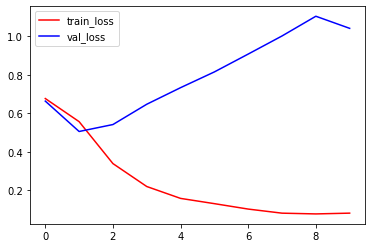

In [51]:
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

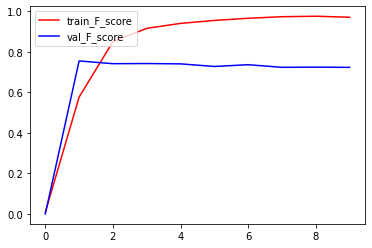

In [52]:
plt.plot(model.history.history["f1_score"], c="r", label="train_F_score")
plt.plot(model.history.history["val_f1_score"], c="b", label="val_F_score")
plt.legend(loc="upper left")
plt.show()

**The model rapidly overfits. F1-score ~0.73**

## Model 2: Simple Recursive Neural Network with dense layers and dropout layers to reduce overfitting

In [53]:
embedding_dim = 64  
vocab_size = len(tokenizer.word_index)

model_2 = Sequential([
  Embedding(vocab_size+1, embedding_dim,input_length = text_pad.shape[1], name="embedding"), 
  SimpleRNN(units=32, return_sequences=False, return_state=False),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(16, activation='relu'),
  Dropout(0.5),
  Dense(8, activation='relu'),
  Dropout(0.5),
  Dense(1, activation="sigmoid")
])

In [54]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])

In [55]:
model_2.fit(train_batch,validation_data=val_batch,epochs=10)

Epoch 1/10
108/108 [==============================] - 4s 21ms/step - loss: 0.6882 - f1_score: 0.2563 - val_loss: 0.6867 - val_f1_score: 0.0000e+00
Epoch 2/10
108/108 [==============================] - 2s 20ms/step - loss: 0.6648 - f1_score: 0.2792 - val_loss: 0.6256 - val_f1_score: 0.5827
Epoch 3/10
108/108 [==============================] - 2s 19ms/step - loss: 0.5927 - f1_score: 0.5972 - val_loss: 0.5839 - val_f1_score: 0.7093
Epoch 4/10
108/108 [==============================] - 2s 19ms/step - loss: 0.4943 - f1_score: 0.7129 - val_loss: 0.5260 - val_f1_score: 0.7444
Epoch 5/10
108/108 [==============================] - 2s 19ms/step - loss: 0.4014 - f1_score: 0.7797 - val_loss: 0.6023 - val_f1_score: 0.7000
Epoch 6/10
108/108 [==============================] - 2s 19ms/step - loss: 0.3389 - f1_score: 0.8341 - val_loss: 0.6054 - val_f1_score: 0.6839
Epoch 7/10
108/108 [==============================] - 2s 20ms/step - loss: 0.2637 - f1_score: 0.8801 - val_loss: 0.6908 - val_f1_score: 0.

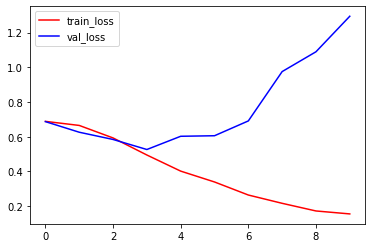

In [56]:
plt.plot(model_2.history.history["loss"], c="r", label="train_loss")
plt.plot(model_2.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

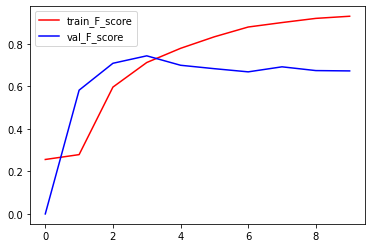

In [57]:
plt.plot(model_2.history.history["f1_score"], c="r", label="train_F_score")
plt.plot(model_2.history.history["val_f1_score"], c="b", label="val_F_score")
plt.legend(loc="upper left")
plt.show()

**No improvement on model 1. Rapid overfitting.**

### Model 3: GRU with dense layers and dropout layers to reduce overfitting

In [58]:
embedding_dim = 64  
vocab_size = len(tokenizer.word_index)

model_3 = Sequential([
  Embedding(vocab_size+1, embedding_dim,input_length = text_pad.shape[1], name="embedding"), 
  GRU(units=32, return_sequences=False, return_state=False),
  Dense(32, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(16, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(8, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(1, activation="sigmoid")
])

In [59]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])
model_3.fit(train_batch,validation_data=val_batch,epochs=10)

Epoch 1/10
108/108 [==============================] - 6s 33ms/step - loss: 0.6881 - f1_score: 0.2232 - val_loss: 0.6891 - val_f1_score: 0.0000e+00
Epoch 2/10
108/108 [==============================] - 3s 30ms/step - loss: 0.6843 - f1_score: 6.8329e-04 - val_loss: 0.6893 - val_f1_score: 0.0000e+00
Epoch 3/10
108/108 [==============================] - 3s 29ms/step - loss: 0.6836 - f1_score: 0.0000e+00 - val_loss: 0.6897 - val_f1_score: 0.0000e+00
Epoch 4/10
108/108 [==============================] - 3s 29ms/step - loss: 0.6828 - f1_score: 0.0000e+00 - val_loss: 0.6900 - val_f1_score: 0.0000e+00
Epoch 5/10
108/108 [==============================] - 3s 29ms/step - loss: 0.6827 - f1_score: 0.0000e+00 - val_loss: 0.6902 - val_f1_score: 0.0000e+00
Epoch 6/10
108/108 [==============================] - 3s 28ms/step - loss: 0.6834 - f1_score: 0.0000e+00 - val_loss: 0.6899 - val_f1_score: 0.0000e+00
Epoch 7/10
108/108 [==============================] - 3s 29ms/step - loss: 0.6832 - f1_score: 0.00

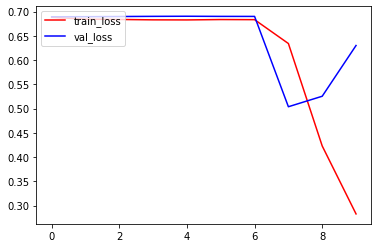

In [60]:
plt.plot(model_3.history.history["loss"], c="r", label="train_loss")
plt.plot(model_3.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

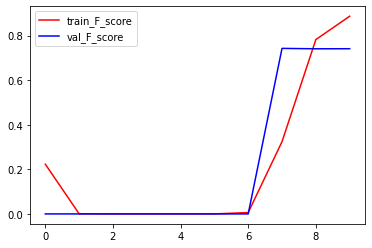

In [61]:
plt.plot(model_3.history.history["f1_score"], c="r", label="train_F_score")
plt.plot(model_3.history.history["val_f1_score"], c="b", label="val_F_score")
plt.legend(loc="upper left")
plt.show()

**No improvement on model 1 and 2**

### Model 4: LSTM with dense layers and dropout layers to reduce overfitting

In [62]:
embedding_dim = 64  
vocab_size = len(tokenizer.word_index)

model_4 = Sequential([
  Embedding(vocab_size+1, embedding_dim,input_length = text_pad.shape[1], name="embedding"), 
  LSTM(units=64, return_sequences=True),
  LSTM(units=32, return_sequences=False),
  Dense(32, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(16, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(1, activation="sigmoid")
])

In [63]:
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])
model_4.fit(train_batch,validation_data=val_batch,epochs=10)

Epoch 1/10
108/108 [==============================] - 10s 60ms/step - loss: 0.6393 - f1_score: 0.4231 - val_loss: 0.5552 - val_f1_score: 0.7219
Epoch 2/10
108/108 [==============================] - 6s 51ms/step - loss: 0.4239 - f1_score: 0.7989 - val_loss: 0.5206 - val_f1_score: 0.7573
Epoch 3/10
108/108 [==============================] - 5s 51ms/step - loss: 0.2650 - f1_score: 0.8937 - val_loss: 0.6067 - val_f1_score: 0.7356
Epoch 4/10
108/108 [==============================] - 6s 53ms/step - loss: 0.1742 - f1_score: 0.9343 - val_loss: 0.6429 - val_f1_score: 0.7196
Epoch 5/10
108/108 [==============================] - 6s 51ms/step - loss: 0.1252 - f1_score: 0.9584 - val_loss: 0.8161 - val_f1_score: 0.7130
Epoch 6/10
108/108 [==============================] - 6s 52ms/step - loss: 0.1075 - f1_score: 0.9645 - val_loss: 0.7916 - val_f1_score: 0.7250
Epoch 7/10
108/108 [==============================] - 6s 52ms/step - loss: 0.0779 - f1_score: 0.9738 - val_loss: 1.2441 - val_f1_score: 0.719

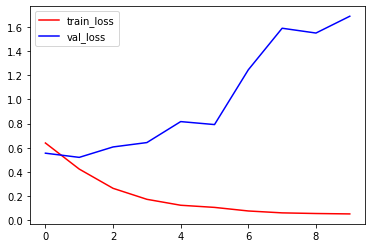

In [64]:
plt.plot(model_4.history.history["loss"], c="r", label="train_loss")
plt.plot(model_4.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

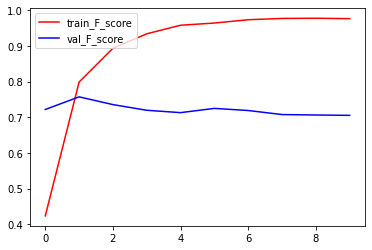

In [65]:
plt.plot(model_4.history.history["f1_score"], c="r", label="train_F_score")
plt.plot(model_4.history.history["val_f1_score"], c="b", label="val_F_score")
plt.legend(loc="upper left")
plt.show()

All models rapidly overfit the training data. A way to reduce overfitting is to use pretrained embedding. I choose to use the pretrained word embedding from https://nlp.stanford.edu/projects/glove/ . Specifically I use pretrained vectorization from a Twitter crawl (2B tweets).

Source : Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf). 

In [11]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.twitter.27B.zip \
     -O /tmp/glove.twitter.27B.zip
    

--2022-07-19 10:19:52--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2022-07-19 10:19:52--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-07-19 10:19:52--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [12]:
import zipfile
with zipfile.ZipFile('/tmp/glove.twitter.27B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [14]:
#extract vectors from txt file

embeddings_index = {}
f = open('/tmp/glove/glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [20]:
word_index = tokenizer.word_index
max_length = 200

#populate embedding matrix with vector values for every word in tokenizer vocabulary
embedding_matrix = np.zeros((len(word_index) + 1, max_length))  
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [66]:
embedding_dim=200 

vocab_size = len(tokenizer.word_index)

model_5 = Sequential([
  Embedding(vocab_size+1, embedding_dim, weights=[embedding_matrix], name="embedding",trainable=False),
  GlobalAveragePooling1D(),
  Dense(128, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(64, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(32, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(16, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(1, activation="sigmoid") 
])

model_5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2826000   
                                                                 
 global_average_pooling1d_7   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_39 (Dense)            (None, 128)               25728     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                     

In [67]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
model_5.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])
model_5.fit(train_batch,validation_data=val_batch,epochs=50)

Epoch 1/50
108/108 [==============================] - 1s 6ms/step - loss: 0.6252 - f1_score: 0.5608 - val_loss: 0.4976 - val_f1_score: 0.7290
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 0.5203 - f1_score: 0.7037 - val_loss: 0.4641 - val_f1_score: 0.7528
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.4959 - f1_score: 0.7254 - val_loss: 0.4575 - val_f1_score: 0.7671
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 0.4812 - f1_score: 0.7285 - val_loss: 0.4607 - val_f1_score: 0.7516
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.4809 - f1_score: 0.7283 - val_loss: 0.4572 - val_f1_score: 0.7603
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.4683 - f1_score: 0.7385 - val_loss: 0.4657 - val_f1_score: 0.7310
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.4644 - f1_score: 0.7404 - val_loss: 0.4612 - val_f1_score: 0.7548
Epoch 

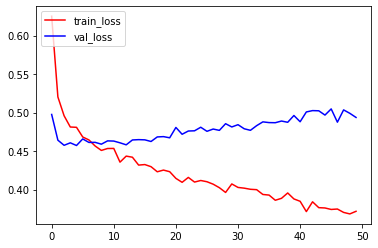

In [68]:
plt.plot(model_5.history.history["loss"], c="r", label="train_loss")
plt.plot(model_5.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

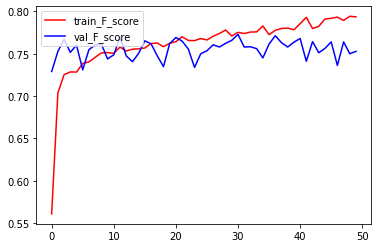

In [69]:
plt.plot(model_5.history.history["f1_score"], c="r", label="train_F_score")
plt.plot(model_5.history.history["val_f1_score"], c="b", label="val_F_score")
plt.legend(loc="upper left")
plt.show()

**Plateau of F1_score and loss function for validation data**

## Same model but with trainable embedding

In [70]:
embedding_dim=200 

vocab_size = len(tokenizer.word_index)

model_5_b = Sequential([
  Embedding(vocab_size+1, embedding_dim, weights=[embedding_matrix], name="embedding",trainable=True),
  GlobalAveragePooling1D(),
  #Dense(64, activation=tf.keras.layers.LeakyReLU()),
  #Dropout(0.5),
  #Dense(32, activation=tf.keras.layers.LeakyReLU()),
  #Dropout(0.5),
  #Dense(16, activation=tf.keras.layers.LeakyReLU()),
  #Dropout(0.5),
  #Dense(8, activation=tf.keras.layers.LeakyReLU()),
  #Dropout(0.5),
  Dense(16, activation="relu"),
  Dropout(0.5),
  Dense(8, activation="relu"),
  Dropout(0.5),
  Dense(1, activation="sigmoid") 
])

model_5_b.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2826000   
                                                                 
 global_average_pooling1d_8   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_44 (Dense)            (None, 16)                3216      
                                                                 
 dropout_32 (Dropout)        (None, 16)                0         
                                                                 
 dense_45 (Dense)            (None, 8)                 136       
                                                                 
 dropout_33 (Dropout)        (None, 8)                 0         
                                                     

In [71]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
model_5_b.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])
model_5_b.fit(train_batch,validation_data=val_batch,epochs=10)

Epoch 1/10
108/108 [==============================] - 5s 36ms/step - loss: 0.6793 - f1_score: 0.4772 - val_loss: 0.6373 - val_f1_score: 0.7035
Epoch 2/10
108/108 [==============================] - 4s 34ms/step - loss: 0.6000 - f1_score: 0.6412 - val_loss: 0.5140 - val_f1_score: 0.7556
Epoch 3/10
108/108 [==============================] - 4s 34ms/step - loss: 0.5130 - f1_score: 0.7262 - val_loss: 0.4543 - val_f1_score: 0.7888
Epoch 4/10
108/108 [==============================] - 4s 35ms/step - loss: 0.4471 - f1_score: 0.7858 - val_loss: 0.4378 - val_f1_score: 0.7848
Epoch 5/10
108/108 [==============================] - 4s 36ms/step - loss: 0.3870 - f1_score: 0.8245 - val_loss: 0.4408 - val_f1_score: 0.7867
Epoch 6/10
108/108 [==============================] - 4s 34ms/step - loss: 0.3429 - f1_score: 0.8529 - val_loss: 0.4662 - val_f1_score: 0.7874
Epoch 7/10
108/108 [==============================] - 4s 34ms/step - loss: 0.3114 - f1_score: 0.8871 - val_loss: 0.4874 - val_f1_score: 0.7806

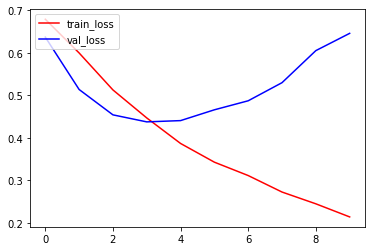

In [72]:
plt.plot(model_5_b.history.history["loss"], c="r", label="train_loss")
plt.plot(model_5_b.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

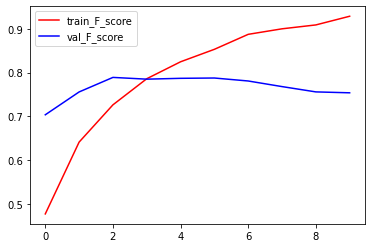

In [73]:
plt.plot(model_5_b.history.history["f1_score"], c="r", label="train_F_score")
plt.plot(model_5_b.history.history["val_f1_score"], c="b", label="val_F_score")
plt.legend(loc="upper left")
plt.show()

In [74]:
embedding_dim=200 

vocab_size = len(tokenizer.word_index)

model_6 = Sequential([
  Embedding(vocab_size+1, embedding_dim, weights=[embedding_matrix], name="embedding",trainable=True),
  LSTM(units=64, return_sequences=False),
  Dense(128, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(64, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(32, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(16, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(8, activation=tf.keras.layers.LeakyReLU()),
  Dropout(0.5),
  Dense(1, activation="sigmoid") 
])

model_6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2826000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                67840     
                                                                 
 dense_47 (Dense)            (None, 128)               8320      
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 32)              

In [36]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
model_6.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])
model_6.fit(train_batch,validation_data=val_batch,epochs=10)

Epoch 1/10
108/108 [==============================] - 11s 79ms/step - loss: 0.5787 - f1_score: 0.6180 - val_loss: 0.4779 - val_f1_score: 0.7180
Epoch 2/10
108/108 [==============================] - 8s 74ms/step - loss: 0.4492 - f1_score: 0.7664 - val_loss: 0.4608 - val_f1_score: 0.7406
Epoch 3/10
108/108 [==============================] - 9s 83ms/step - loss: 0.3608 - f1_score: 0.8376 - val_loss: 0.5025 - val_f1_score: 0.7699
Epoch 4/10
108/108 [==============================] - 9s 86ms/step - loss: 0.2808 - f1_score: 0.8753 - val_loss: 0.5269 - val_f1_score: 0.7754
Epoch 5/10
108/108 [==============================] - 14s 125ms/step - loss: 0.2233 - f1_score: 0.9050 - val_loss: 0.8627 - val_f1_score: 0.7453
Epoch 6/10
108/108 [==============================] - 8s 74ms/step - loss: 0.1586 - f1_score: 0.9373 - val_loss: 0.8168 - val_f1_score: 0.7504
Epoch 7/10
108/108 [==============================] - 8s 73ms/step - loss: 0.1304 - f1_score: 0.9455 - val_loss: 1.0249 - val_f1_score: 0.7

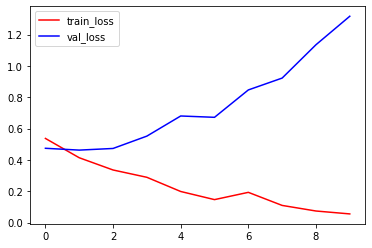

In [ ]:
plt.plot(model_6.history.history["loss"], c="r", label="train_loss")
plt.plot(model_6.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

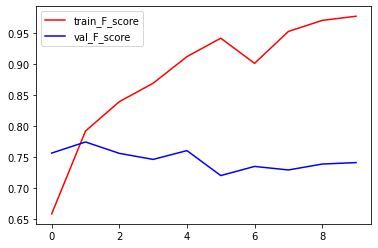

In [ ]:
plt.plot(model_6.history.history["f1_score"], c="r", label="train_F_score")
plt.plot(model_6.history.history["val_f1_score"], c="b", label="val_F_score")
plt.legend(loc="upper left")
plt.show()

In [40]:
#retrain on whole dataset
retrain = tf.data.Dataset.from_tensor_slices((text_pad, tweets.target))

retrain_batch = train.shuffle(len(retrain)).batch(64)

In [44]:
model_5_b.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[f1])
model_5_b.fit(retrain_batch,epochs=4)

Epoch 1/4
108/108 [==============================] - 4s 32ms/step - loss: 0.6707 - f1_score: 0.7382
Epoch 2/4
108/108 [==============================] - 3s 32ms/step - loss: 0.5957 - f1_score: 0.6357
Epoch 3/4
108/108 [==============================] - 3s 32ms/step - loss: 0.5258 - f1_score: 0.6951
Epoch 4/4
108/108 [==============================] - 3s 32ms/step - loss: 0.4565 - f1_score: 0.7576


In [37]:
#fetch test data
test = pd.read_csv("/content/test.csv")
test.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [38]:
# remove https
# remove capital letters 
# remove special symbols 
# tokenize, lemmatize, remove stop words
test['location'] = test['location'].fillna(" ")
test['text_location'] = test['text'] + " " + test['location']
test['text_clean'] = test['text_location'].str.replace(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", " ")
test['text_clean'] = test['text_clean'].str.replace(r"@[-a-zA-Z0-9@:%._\+~#=]{1,256}\s", " ")
test['text_clean'] = test['text_clean'].str.replace(r"\&(.*?)\;", " ")
test['text_clean'] = test['text_clean'].str.replace(r"\n", " ")
test['text_clean'] = test['text_clean'].str.replace(r"åÊ", " ")
test['text_clean'] = test['text_clean'].str.replace(r"ÛÓ", " ")
test['text_clean'] = test['text_clean'].str.replace(r"ÛÒ", " ")
test['text_clean'] = test['text_clean'].str.replace(r"Û", " ")
test['text_clean'] = test['text_clean'].str.replace(r"[!@#$%^&*(),.?\\/\":{}|<>ã¢;ª-]", " ")
#test['text_clean'] = test['text_clean'].str.replace(r"[0-9]+", " ")
test['text_clean'] = test['text_clean'].str.replace(r"\s[a-z]\s", " ")
test['text_clean'] = test['text_clean'].str.replace(r"\s[a-z]\s", " ")

test['text_clean'] = test['text_clean'].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
test['text_clean'] = test['text_clean'].apply(lambda x: x.replace(" +"," ").lower().strip())
test['text_clean'] = test['text_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
test['text_clean'] = test['text_clean'].str.replace(r"[']", " ")
test['text_clean'] = test['text_clean'].str.replace(r"[']", " ")

test["text_encoded"] = tokenizer.texts_to_sequences(test.text_clean)
test["len_text"] = test["text_encoded"].apply(lambda x: len(x))

test_pad = tf.keras.preprocessing.sequence.pad_sequences(test.text_encoded, padding="post")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: Fut

In [45]:
pred = model_5_b.predict(test_pad)
test_prediction = pd.DataFrame(test['id'] )
test_prediction['pred'] = pred
test_prediction['target'] = test_prediction['pred'].apply(lambda x: 0 if x<0.5 else 1)
test_prediction = test_prediction[['id', 'target']]
test_prediction.to_csv('/content/predictions.csv', index=False)

**F1-score on Kaggle: 0.81152**

**Leaderboard Position: 237**